### Data loading

In [2]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
  
# fetch dataset 
aids_clinical_trials_group_study_175 = fetch_ucirepo(id=890) 
  
# data (as pandas dataframes) 
X = aids_clinical_trials_group_study_175.data.features 
y = aids_clinical_trials_group_study_175.data.targets 
  
# Print variable information 
print(aids_clinical_trials_group_study_175.variables) 

       name     role        type         demographic  \
0    pidnum       ID     Integer                None   
1       cid   Target      Binary                None   
2      time  Feature     Integer                None   
3       trt  Feature     Integer                None   
4       age  Feature     Integer                 Age   
5      wtkg  Feature  Continuous                None   
6      hemo  Feature      Binary                None   
7      homo  Feature      Binary  Sexual Orientation   
8     drugs  Feature      Binary                None   
9    karnof  Feature     Integer                None   
10   oprior  Feature      Binary                None   
11      z30  Feature      Binary                None   
12   zprior  Feature      Binary                None   
13  preanti  Feature     Integer                None   
14     race  Feature     Integer                Race   
15   gender  Feature      Binary              Gender   
16     str2  Feature      Binary                

In [3]:
X.head()

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,gender,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820
0,948,2,48,89.8128,0,0,0,100,0,0,...,0,0,1,0,1,0,422,477,566,324
1,1002,3,61,49.4424,0,0,0,90,0,1,...,0,1,3,0,1,0,162,218,392,564
2,961,3,45,88.4520,0,1,1,90,0,1,...,1,1,3,0,1,1,326,274,2063,1893
3,1166,3,47,85.2768,0,1,0,100,0,1,...,1,1,3,0,1,0,287,394,1590,966
4,1090,0,43,66.6792,0,1,0,100,0,1,...,1,1,3,0,0,0,504,353,870,782


### Preprocessing

In [4]:
X['cd420_cd40_diff'] = X['cd420'] - X['cd40']
X['cd820_cd80_diff'] = X['cd820'] - X['cd80']

# exclude columns from X
X = X.drop(columns=['time'])
X = X.drop(columns=['zprior'])
X = X.drop(columns=['str2'])
X = X.drop(columns=['treat'])

# copy X to new variable
X_bin = X.copy()

# binarise strat column
X_bin = pd.get_dummies(X_bin, columns=['strat'])
X_bin = X_bin.drop(columns=['strat_1'])

# binarise trt column
X_bin = pd.get_dummies(X_bin, columns=['trt'])
X_bin = X_bin.drop(columns=['trt_0'])

/var/folders/p2/19szx7gd5jbft0v3d0s11vdm0000gp/T/ipykernel_3331/139946427.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cd420_cd40_diff'] = X['cd420'] - X['cd40']


Creating a training and a test dataset.

In [5]:
# split to train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
X_bin_train, X_bin_test, y_bin_train, y_bin_test = train_test_split(X_bin, y, test_size=0.25, random_state=0)

In [8]:
# using random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import numpy as np
clf=RandomForestClassifier(n_estimators=1000, random_state=0)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print("Accuracy with Random forest:",metrics.accuracy_score(y_test, y_pred))

# use Bayesian optimization to tune hyperparameters
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from skopt.space import Real, Categorical, Integer

# define the search space
opt = BayesSearchCV(
    RandomForestClassifier(),
    {
        'n_estimators': Integer(100, 2500),
        'max_depth': Integer(3, 100),
        'max_features': Categorical(['auto', 'sqrt', 'log2']),
        'min_samples_split': Integer(2, 10),
        'min_samples_leaf': Integer(1, 10),
        'bootstrap': Categorical([True, False])
    },
    n_iter=200,
    random_state=0,
    cv=StratifiedKFold(5),
    n_jobs=4
)

# perform the search
np.int = int
opt.fit(X_train, y_train)

# get the best hyperparameters
print(opt.best_params_)
print(opt.best_score_)

best_params = opt.best_params_

# Train a model using the best hyperparameters
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train, y_train)

# Make predictions on new data
y_pred_opt = best_model.predict(X_test)

print("Accuracy with Random forest after hyperparameter tuning:",metrics.accuracy_score(y_test, y_pred_opt))


/var/folders/p2/19szx7gd5jbft0v3d0s11vdm0000gp/T/ipykernel_3331/3091687466.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train,y_train)


Accuracy with Random forest: 0.7981308411214953


/Users/sberegi/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/sberegi/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/sberegi/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/sberegi/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686:

OrderedDict([('bootstrap', True), ('max_depth', 83), ('max_features', 'auto'), ('min_samples_leaf', 9), ('min_samples_split', 2), ('n_estimators', 1700)])
0.7880315420560747


/var/folders/p2/19szx7gd5jbft0v3d0s11vdm0000gp/T/ipykernel_3331/3091687466.py:48: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  best_model.fit(X_train, y_train)
/Users/sberegi/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Accuracy with Random forest after hyperparameter tuning: 0.7962616822429907


Accuracy with Random forest: 0.7925233644859813


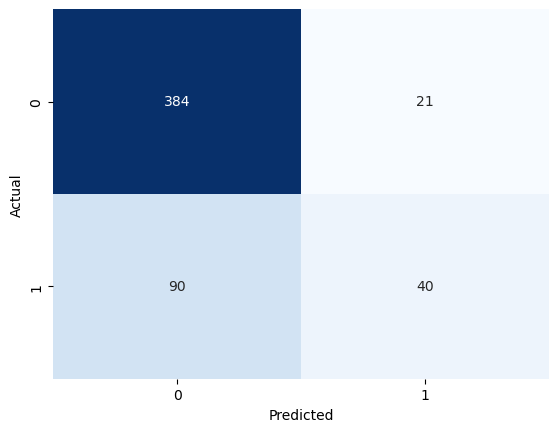

Sensitivity :  0.810126582278481
Specificity :  0.6557377049180327


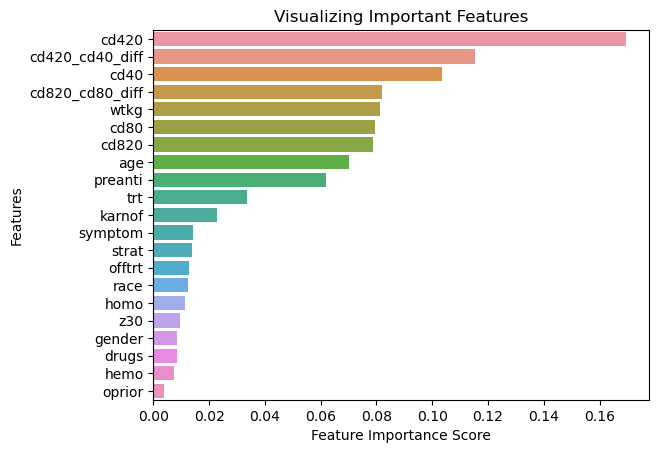

In [7]:

print("Accuracy with Random forest:",metrics.accuracy_score(y_test, y_pred_opt))

# plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(y_test, y_pred_opt)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# sensitivity and specificity
total=sum(sum(conf_mat))
sensitivity = conf_mat[0,0]/(conf_mat[0,0]+conf_mat[1,0])
print('Sensitivity : ', sensitivity )

specificity = conf_mat[1,1]/(conf_mat[1,1]+conf_mat[0,1])
print('Specificity : ', specificity)

# display feature importance
import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()